# Map Alignment

The pyOpenMS map alignment algorithms transform different maps (peak
maps,
[feature maps](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-feature-maps))
to a common retention time axis.

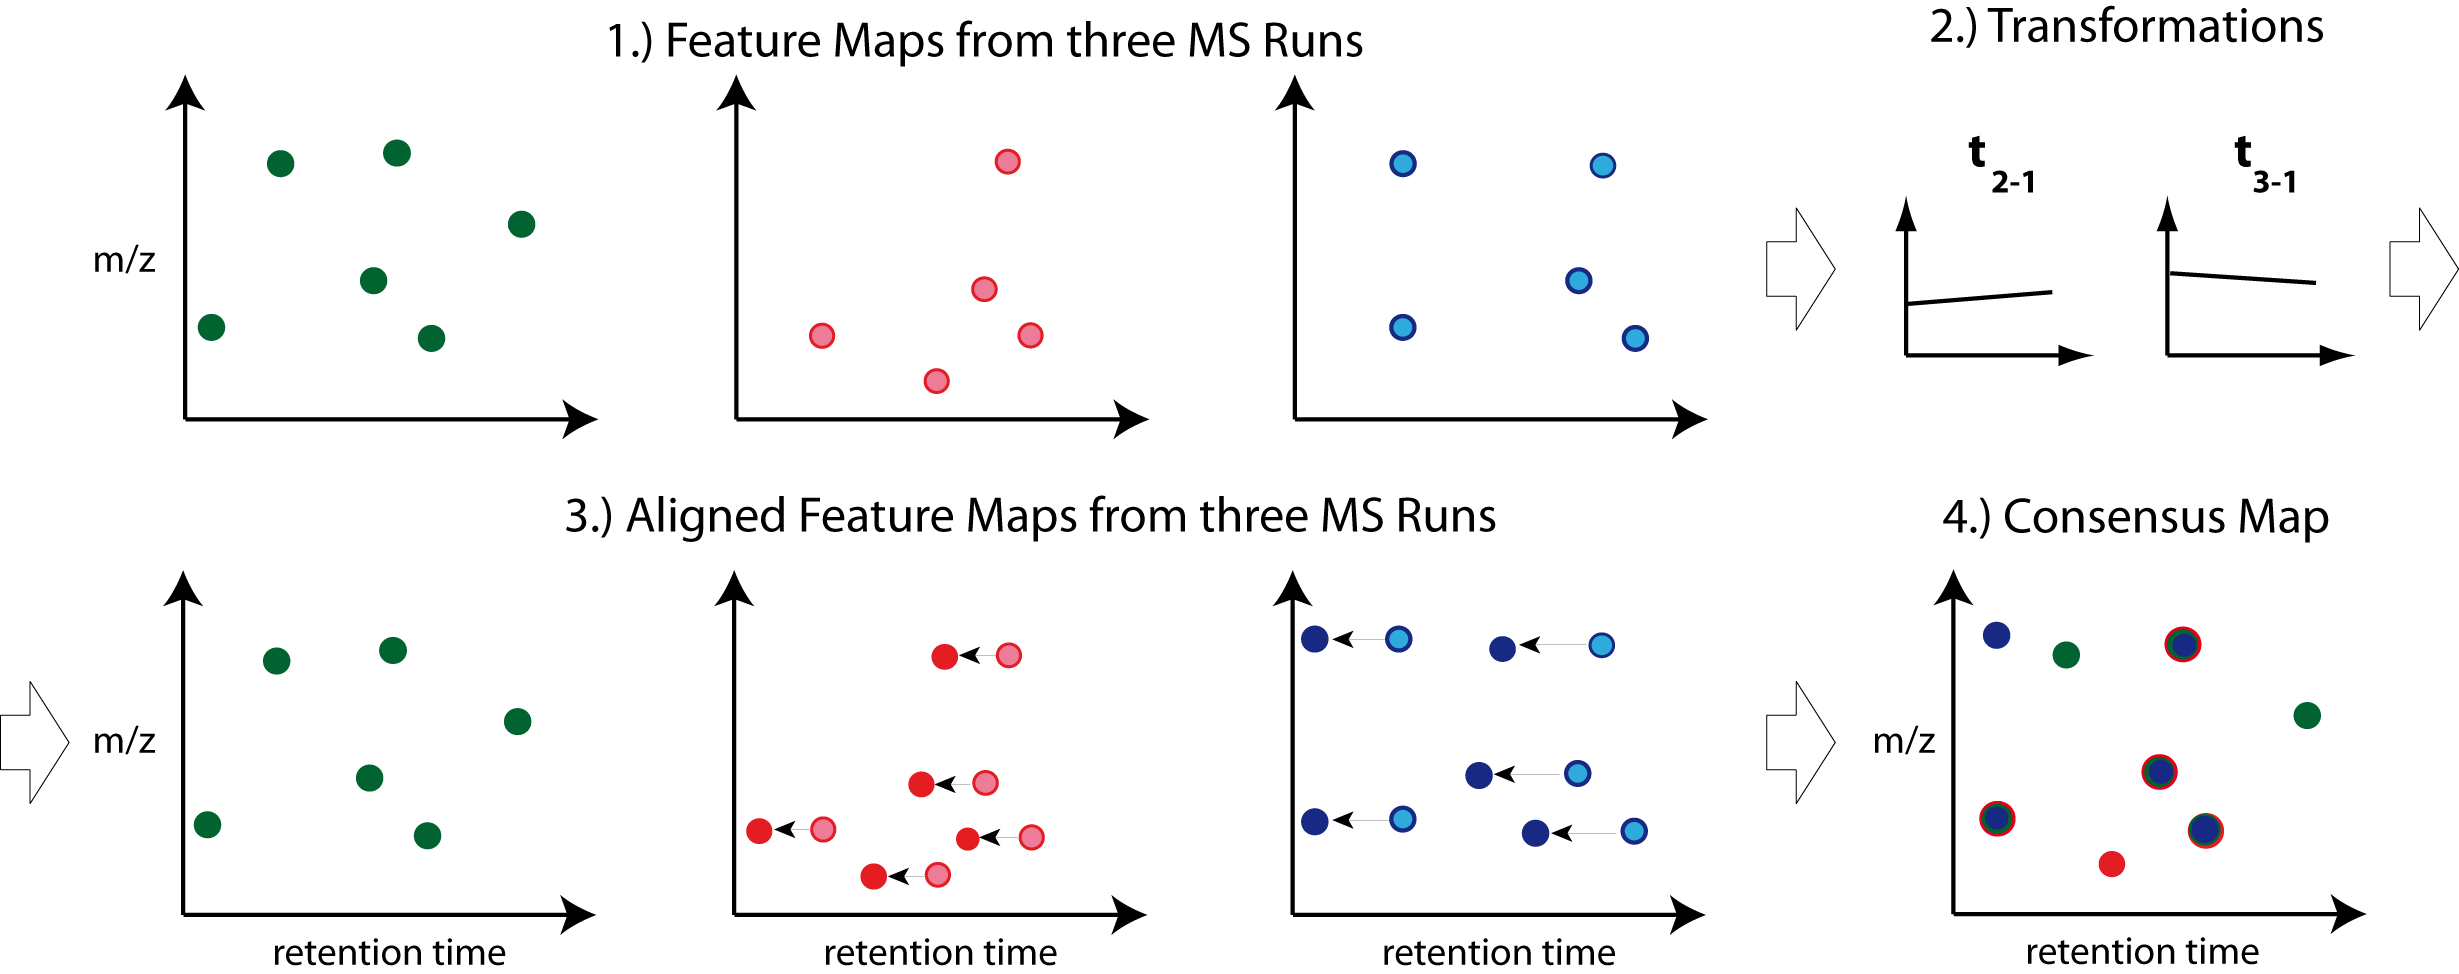

Note: Creating a
[consensus map](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-consensus-map)
from the aligned maps is performed by a features linking algorithm (see
next chapter).

Different map alignment algorithms are available in pyOpenMS:

-   [MapAlignmentAlgorithmPoseClustering](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmPoseClustering.html)
-   [MapAlignmentAlgorithmIdentification](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmIdentification.html)
-   [MapAlignmentAlgorithmSpectrumAlignment](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmSpectrumAlignment.html)
-   [MapAlignmentAlgorithmKD](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmKD.html)
-   [MapAlignmentTransformer](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentTransformer.html)

To perform a simple linear alignment we can employ the algorithm
[MapAlignmentAlgorithmPoseClustering](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmPoseClustering.html).
In the example below it is used for the alignment of
[feature maps](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-feature-maps).

## Download Example Data

In [ ]:
import pyopenms as oms
from urllib.request import urlretrieve

base_url = (
    "https://raw.githubusercontent.com/OpenMS/pyopenms-docs/master/src/data/"
)

feature_files = [
    "BSA1_F1.featureXML",
    "BSA2_F1.featureXML",
    "BSA3_F1.featureXML",
]

feature_maps = []

# download the feature files and store feature maps in list (feature_maps)
for feature_file in feature_files:
    urlretrieve(base_url + feature_file, feature_file)
    feature_map = oms.FeatureMap()
    oms.FeatureXMLFile().load(feature_file, feature_map)
    feature_maps.append(feature_map)

## Map Alignment Algorithm

From the list of
[feature maps](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-feature-maps),
the one with the largest number of features is selected for reference.
The retention times of the other
[feature maps](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-feature-maps)
are aligned to this.

In [ ]:
# set ref_index to feature map index with largest number of features
ref_index = [
    i[0]
    for i in sorted(
        enumerate([fm.size() for fm in feature_maps]), key=lambda x: x[1]
    )
][-1]

aligner = oms.MapAlignmentAlgorithmPoseClustering()

aligner.setReference(feature_maps[ref_index])

# perform alignment and transformation of feature maps to the reference map (exclude reference map)
for feature_map in feature_maps[:ref_index] + feature_maps[ref_index + 1 :]:
    trafo = oms.TransformationDescription()
    aligner.align(feature_map, trafo)
    transformer = oms.MapAlignmentTransformer()
    transformer.transformRetentionTimes(
        feature_map, trafo, True
    )  # store original RT as meta value

## Visualization

Plotting
[consensus maps](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-consensus-maps)
with features before and after alignment.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fmaps = (
    [feature_maps[ref_index]]
    + feature_maps[:ref_index]
    + feature_maps[ref_index + 1 :]
)

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1)
ax.set_title("consensus map before alignment")
ax.set_ylabel("m/z")
ax.set_xlabel("RT")

# use alpha value to display feature intensity
ax.scatter(
    [f.getRT() for f in fmaps[0]],
    [f.getMZ() for f in fmaps[0]],
    alpha=np.asarray([f.getIntensity() for f in fmaps[0]])
    / max([f.getIntensity() for f in fmaps[0]]),
)

for fm in fmaps[1:]:
    ax.scatter(
        [f.getMetaValue("original_RT") for f in fm],
        [f.getMZ() for f in fm],
        alpha=np.asarray([f.getIntensity() for f in fm])
        / max([f.getIntensity() for f in fm]),
    )

ax = fig.add_subplot(1, 2, 2)
ax.set_title("consensus map after alignment")
ax.set_xlabel("RT")

for fm in fmaps:
    ax.scatter(
        [f.getRT() for f in fm],
        [f.getMZ() for f in fm],
        alpha=np.asarray([f.getIntensity() for f in fm])
        / max([f.getIntensity() for f in fm]),
    )

fig.tight_layout()
fig.legend(
    [
        fmap.getDataProcessing()[0].getMetaValue("parameter: out")[:-11]
        for fmap in fmaps
    ],
    loc="lower center",
)
fig.show()

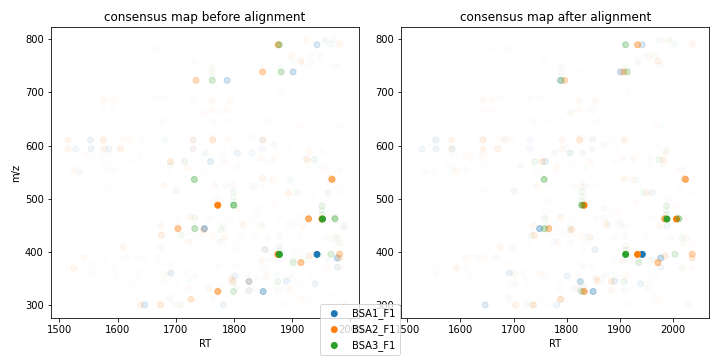